In [4]:
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import gdown
import os

In [55]:
# Configuration variables
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size= 160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

In [31]:
data_path = "../data"
data_folder_path = os.path.join(data_path, "C3E3-StanfordData/")

In [35]:
os.makedirs(data_folder_path)

# Processed training data
gdown.download(id="1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ", output=data_folder_path)

# 100 dimension version of GloVe from Stanford
gdown.download(id="1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g", output=data_folder_path)

Downloading...
From: https://drive.google.com/uc?id=1wd8KaeCSHxt-nEpMeuHFSNWrDp8joUXJ
To: /Users/olestole/code/kurs/tensorflow_specialty/data/C3E3-StanfordData/training_cleaned.csv
100%|██████████| 239M/239M [01:08<00:00, 3.47MB/s]
Downloading...
From: https://drive.google.com/uc?id=1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g
To: /Users/olestole/code/kurs/tensorflow_specialty/data/C3E3-StanfordData/glove.6B.100d.txt
100%|██████████| 347M/347M [01:54<00:00, 3.03MB/s]


'../data/C3E3-StanfordData/glove.6B.100d.txt'

In [56]:
training_path = os.path.join(data_folder_path, "training_cleaned.csv")
num_sentences = 0
corpus = []

with open(training_path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # list_item[0] = text
        # list_item[1] = label -> 0/1
        list_item = []
        list_item.append(row[5])
        if (row[0] == '0'):
            list_item.append(0)
        elif (row[0] == '4'):
            list_item.append(1)
        else:
            print("Error!")
        
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [57]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [58]:
sentences = []
labels = []
random.shuffle(corpus)

for i in range(training_size):
    sentences.append(corpus[i][0])
    labels.append(corpus[i][1])

# Create a tokenizer from the corpus
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Split the sequences to training-/validation-sets
split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [59]:
print(vocab_size)
print(word_index['i'])

138230
2


In [60]:
embeddings_path = os.path.join(data_folder_path, "glove.6B.100d.txt")

embeddings_index = {}
with open(embeddings_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [61]:
# print(embeddings_index)
print(len(embeddings_matrix))

138231


In [79]:
# Create the model to fit the subwords
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 16, 100)           13823100  
                                                                 
 conv1d_25 (Conv1D)          (None, 12, 64)            32064     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 3, 64)            0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_40 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13,888,253
Trainable params: 65,153
Non-trainable params: 13,823,100
____________________________________

In [80]:
num_epochs = 5

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/5
4500/4500 - 16s - loss: 0.5490 - accuracy: 0.7142 - val_loss: 0.5200 - val_accuracy: 0.7362 - 16s/epoch - 3ms/step
Epoch 2/5
4500/4500 - 14s - loss: 0.5024 - accuracy: 0.7509 - val_loss: 0.5297 - val_accuracy: 0.7247 - 14s/epoch - 3ms/step
Epoch 3/5
4500/4500 - 12s - loss: 0.4784 - accuracy: 0.7656 - val_loss: 0.5118 - val_accuracy: 0.7465 - 12s/epoch - 3ms/step
Epoch 4/5
4500/4500 - 13s - loss: 0.4583 - accuracy: 0.7794 - val_loss: 0.5104 - val_accuracy: 0.7484 - 13s/epoch - 3ms/step
Epoch 5/5
4500/4500 - 12s - loss: 0.4399 - accuracy: 0.7905 - val_loss: 0.5131 - val_accuracy: 0.7460 - 12s/epoch - 3ms/step


<Figure size 432x288 with 0 Axes>

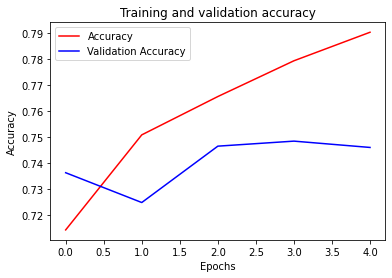

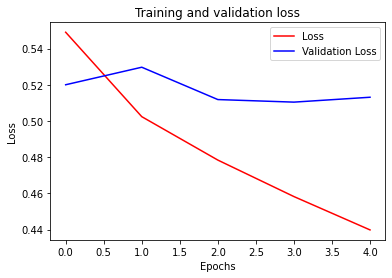

<Figure size 432x288 with 0 Axes>

In [81]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

In [113]:
def make_sentiment_prediction(prediction_sentences):
    prediction_sequences = tokenizer.texts_to_sequences(prediction_sentences)
    padded_prediction_sequences = pad_sequences(prediction_sequences, maxlen=max_length)
    predictions = model.predict(padded_prediction_sequences)
    for index, prediction in enumerate(predictions):
        label = 0 if prediction < 0.5 else 1
        meaning = "Positive" if label else "Negative"
        print(f"{label} - {meaning}:\t {prediction_sentences[index]}")

prediction_sentences = [
    "I hate eating dinner every day, I'm so full of this shit",
    "I love everything in this world, it's all so beautiful",
    "The sky is so pretty",
    "I might die soon",
    "Donald Trump is the worst president of all times",
]

make_sentiment_prediction(prediction_sentences)

0 - Negative:	 I hate eating dinner every day, I'm so full of this shit
1 - Positive:	 I love everything in this world, it's all so beautiful
1 - Positive:	 The sky is so pretty
0 - Negative:	 I might die soon
0 - Negative:	 Donald Trump is the worst president of all times
